In [44]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import joblib
from sklearn.metrics import (
    classification_report, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
import os

# Import the dataloader function from 6_dataloader.py
from dataloader import get_dataloaders  

In [45]:
# ========== LOAD DATA ==========
structural_path = "./data/merged/processed_urls.csv"
embeddings_path = "./data/merged/url_embeddings.csv"

# Load DataLoaders
train_loader, val_loader, test_loader = get_dataloaders(structural_path, embeddings_path, merge_embeddings=True)

In [46]:
# Convert PyTorch DataLoader to NumPy Arrays
def dataloader_to_numpy(dataloader):
    """ Converts a PyTorch DataLoader to NumPy arrays for training XGBoost. """
    X_list, y_list = [], []
    for X_batch, y_batch in dataloader:
        X_list.append(X_batch.numpy())
        y_list.append(y_batch.numpy())
    return np.vstack(X_list), np.concatenate(y_list)

X_train, y_train = dataloader_to_numpy(train_loader)
X_val, y_val = dataloader_to_numpy(val_loader)
X_test, y_test = dataloader_to_numpy(test_loader)

In [47]:
# Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [48]:
# ========== TRAIN XGBOOST MODEL ==========
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "multi:softprob",
    "num_class": len(np.unique(y_train)),  # Number of classes
    "eval_metric": "mlogloss",
    "eta": 0.1,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42
}

# Train model with early stopping
num_rounds = 1000
early_stopping_rounds = 50
evals = [(dtrain, "train"), (dval, "val")]

evals_result = {}
model = xgb.train(params, dtrain, num_rounds, evals, evals_result=evals_result, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

c:\Users\sarim\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:1.44757	val-mlogloss:1.45064
[1]	train-mlogloss:1.31629	val-mlogloss:1.32143
[2]	train-mlogloss:1.20801	val-mlogloss:1.21443
[3]	train-mlogloss:1.11159	val-mlogloss:1.11918
[4]	train-mlogloss:1.02787	val-mlogloss:1.03665
[5]	train-mlogloss:0.95368	val-mlogloss:0.96437
[6]	train-mlogloss:0.88892	val-mlogloss:0.90117
[7]	train-mlogloss:0.83009	val-mlogloss:0.84401
[8]	train-mlogloss:0.77904	val-mlogloss:0.79445
[9]	train-mlogloss:0.73326	val-mlogloss:0.75032
[10]	train-mlogloss:0.69046	val-mlogloss:0.70830
[11]	train-mlogloss:0.65222	val-mlogloss:0.67116
[12]	train-mlogloss:0.61718	val-mlogloss:0.63739
[13]	train-mlogloss:0.58516	val-mlogloss:0.60648
[14]	train-mlogloss:0.55603	val-mlogloss:0.57805
[15]	train-mlogloss:0.52905	val-mlogloss:0.55248
[16]	train-mlogloss:0.50466	val-mlogloss:0.52953
[17]	train-mlogloss:0.48183	val-mlogloss:0.50771
[18]	train-mlogloss:0.46122	val-mlogloss:0.48787
[19]	train-mlogloss:0.44201	val-mlogloss:0.46971
[20]	train-mlogloss:0.42372	va

In [50]:
# Save the best model
os.makedirs("./models", exist_ok=True)
joblib.dump(model, "./models/best_xgboost_model.pkl")
print("✅ Best XGBoost model saved as best_xgboost_model.pkl")

✅ Best XGBoost model saved as best_xgboost_model.pkl



📊 XGBoost Classification Report for Train:
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      9540
  defacement       1.00      1.00      1.00      9496
     malware       1.00      1.00      1.00      9576
    phishing       1.00      1.00      1.00      9525
        spam       1.00      1.00      1.00      9548

    accuracy                           1.00     47685
   macro avg       1.00      1.00      1.00     47685
weighted avg       1.00      1.00      1.00     47685



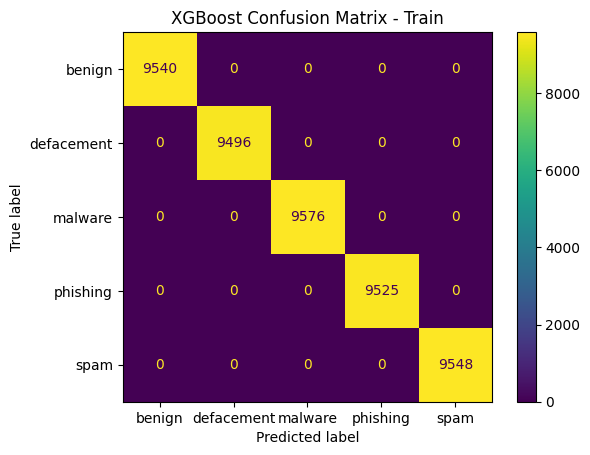


📊 XGBoost Classification Report for Validation:
              precision    recall  f1-score   support

      benign       0.94      0.95      0.95      1192
  defacement       0.96      0.99      0.97      1240
     malware       0.99      0.94      0.96      1175
    phishing       0.91      0.91      0.91      1176
        spam       0.99      1.00      1.00      1177

    accuracy                           0.96      5960
   macro avg       0.96      0.96      0.96      5960
weighted avg       0.96      0.96      0.96      5960



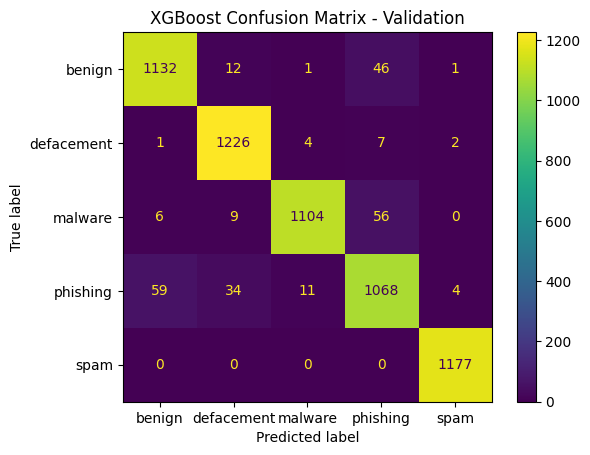


📊 XGBoost Classification Report for Test:
              precision    recall  f1-score   support

      benign       0.95      0.93      0.94      1189
  defacement       0.96      0.99      0.97      1185
     malware       0.98      0.95      0.97      1170
    phishing       0.90      0.92      0.91      1220
        spam       1.00      1.00      1.00      1196

    accuracy                           0.96      5960
   macro avg       0.96      0.96      0.96      5960
weighted avg       0.96      0.96      0.96      5960



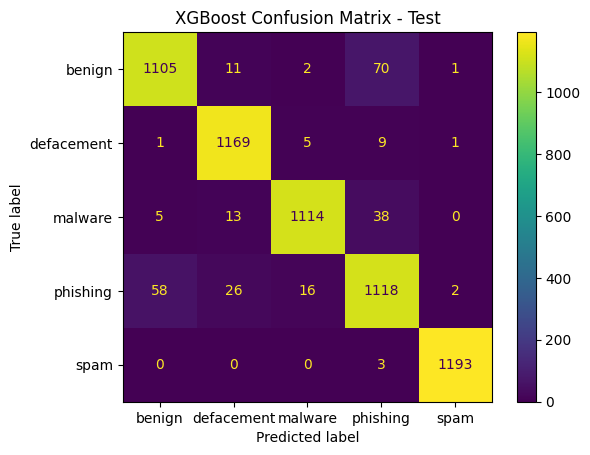

In [51]:

# ========== EVALUATION ==========
def evaluate_and_plot(model, X, y, dataset_name):
    """ Generate classification report & confusion matrix for given dataset """
    dmatrix = xgb.DMatrix(X)
    y_pred = model.predict(dmatrix)
    y_pred = np.argmax(y_pred, axis=1)

    # Classification Report
    print(f"\n📊 XGBoost Classification Report for {dataset_name}:")
    print(classification_report(y, y_pred, target_names=list(label_mapping.values())))

    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels=list(label_mapping.values()))
    plt.title(f"XGBoost Confusion Matrix - {dataset_name}")
    plt.show()

label_mapping = {0: 'benign', 1: 'defacement', 2: 'malware', 3: 'phishing', 4: 'spam'}


# Evaluate on Train, Validation, and Test sets
evaluate_and_plot(model, X_train, y_train, "Train")
evaluate_and_plot(model, X_val, y_val, "Validation")
evaluate_and_plot(model, X_test, y_test, "Test")


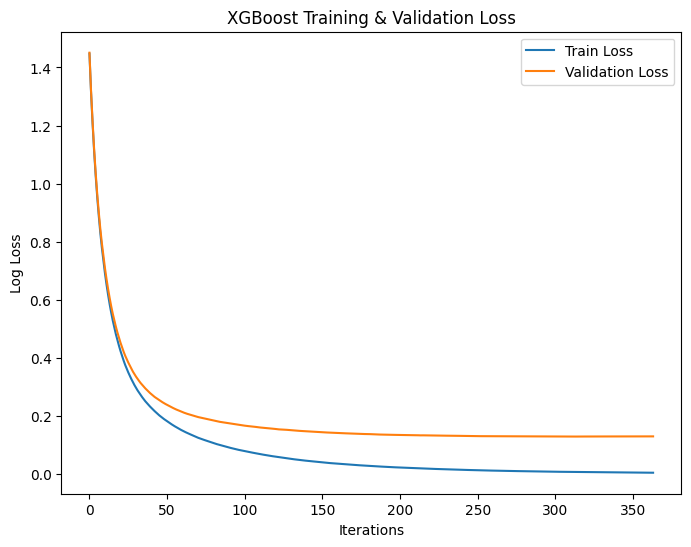

In [52]:

# ========== PLOT TRAINING LOSS ==========

plt.figure(figsize=(8, 6))
plt.plot(evals_result["train"]["mlogloss"], label="Train Loss")
plt.plot(evals_result["val"]["mlogloss"], label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.legend()
plt.title("XGBoost Training & Validation Loss")
plt.show()


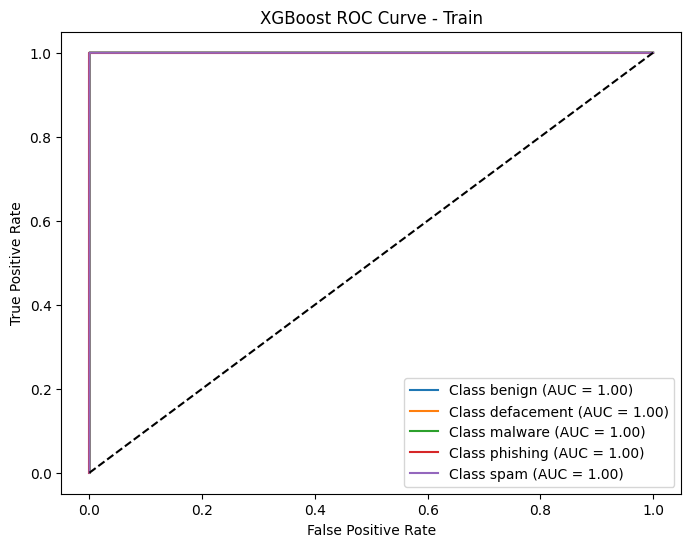

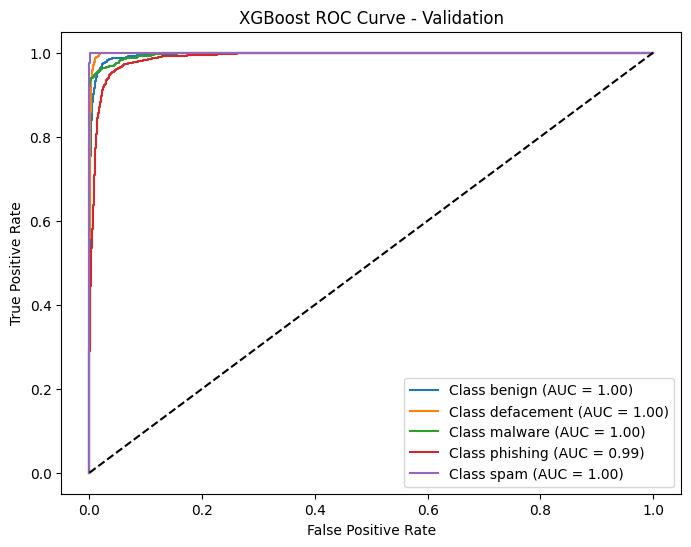

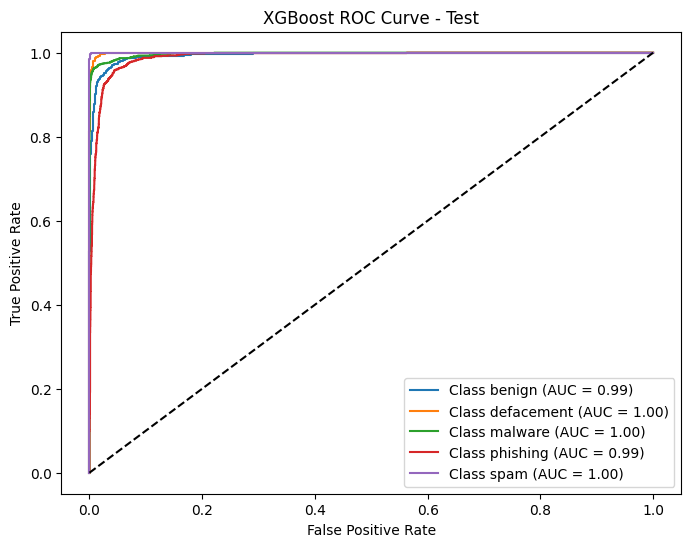

In [57]:
# ========== PLOT ROC CURVE ==========
def plot_roc_curve(model, X, y, dataset_name):
    """ Plots ROC curve and calculates AUC score for multi-class classification. """
    dmatrix = xgb.DMatrix(X)
    y_probs = model.predict(dmatrix)  # Predict using booster
    # Binarize true labels for multi-class ROC AUC
    y_bin = label_binarize(y, classes=np.unique(y))

    label_mapping = {0: 'benign', 1: 'defacement', 2: 'malware', 3: 'phishing', 4: 'spam'}
    class_names = list(label_mapping.values())

    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_probs[:, i])  # Use probabilities directly
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")  # Diagonal baseline
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"XGBoost ROC Curve - {dataset_name}")
    plt.legend()
    plt.show()

# Plot ROC Curves
plot_roc_curve(model, X_train, y_train, "Train")
plot_roc_curve(model, X_val, y_val, "Validation")
plot_roc_curve(model, X_test, y_test, "Test")